# HoughCircles for DE tracking

In this notebook, I implement the droplet tracking software using the HoughCircles algorithm.

I tried to use predictive cropping to avoid false positive detection, and to improve tracking efficiency (section 0). However, the cropping often goes to wrong places and never goes back when some images have low circle quality. Due to this reason, I switch back to the whole image detection for the moment (section 1). 

To improve the tracking accuracy, I use local minimum to correct the boundary location of detected circle (section 2). This gives the results subpixel accuracy, and more well defined circle position (circle goes through the darkest pixels). 

At the end, I generate the final inner droplet trajectory by subtracting outer trajectory from inner trajectory (section 3). 

In [1]:
import numpy as np
from skimage import io, filters, draw
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatch
from corrLib import readdata
from IPython.display import clear_output
import pandas as pd
from myImageLib import to8bit, show_progress, bestcolor, gauss1
import time
import trackpy as tp
import json
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import cv2
from scipy.signal import argrelextrema, argrelmin
from scipy.ndimage import gaussian_filter1d
from de_utils import *

## 0 Work code

### 0.1 Link traj manually

In [3]:
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\07"
img_folder = r"D:\DE\06012022\07\8-bit"
t1 = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1l.csv"))

([<matplotlib.axis.XTick at 0x1d8f17687f0>], [Text(0, 0, '')])

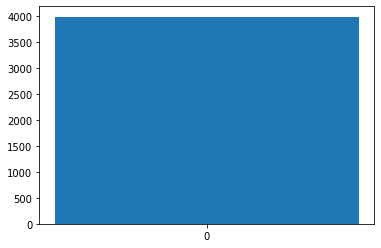

In [4]:
# particle number histogram
count_list = []
for _, g in t1.groupby("particle"):
    count_list.append(len(g))
plt.bar(t1.particle.drop_duplicates().astype("string"), count_list)
plt.xticks(t1.particle.drop_duplicates().astype("string"))

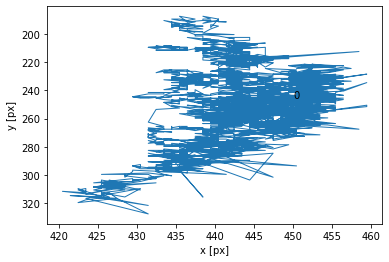

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [5]:
tp.plot_traj(t1, label="particle")

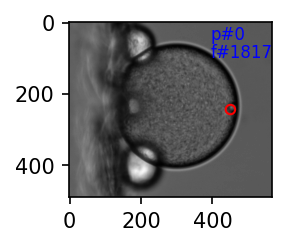

In [7]:
# check which particle is True inner droplet and which is false detection
n_images = len(t1.particle.drop_duplicates())
ncols = 4
nrows = n_images // ncols
if n_images % ncols != 0:
    nrows += 1
fig = plt.figure(figsize=(2*ncols, 2*nrows), dpi=150)
count = 1
for particle in t1.particle.drop_duplicates():
    sub_traj = t1.loc[t1.particle==particle]
    ax = fig.add_subplot(nrows, ncols, count)
    count += 1
    for num, i in sub_traj.iterrows():   
        img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(int(i.frame))))
        ax.imshow(img, cmap="gray")
        circle_object = mpatch.Circle((i.x, i.y), i.r, 
                                     fill=False, ec='red', lw=1)
        ax.add_patch(circle_object)
        ax.annotate("p#{:d}".format(particle), (0.7, 0.9), xycoords="axes fraction", color="blue", fontsize=8)
        ax.annotate("f#{:d}".format(int(i.frame)), (0.7, 0.8), xycoords="axes fraction", color="blue", fontsize=8)
#         plt.pause(0.1)
#         plt.close()
        break

In [298]:
t1 = t1.query("particle not in [5525, 5885, 7083, 7798, 8228, 8765, 9931]")

In [21]:
# print duplicated frames (frames with more than 1 particles)
try:
    dup = pd.concat(g for _, g in t1.groupby("frame") if len(g) > 1)
    dup.head()
except:
    print("No dup")

No dup


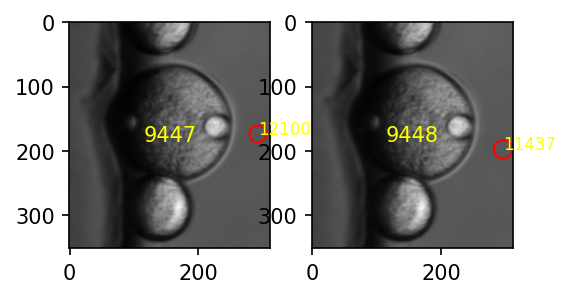

In [237]:
# plot duplicates
img_folder = r"D:\DE\06012022\01\8-bit"
n_images = len(dup.index.drop_duplicates())
ncols = 4
nrows = n_images // ncols
if n_images % ncols != 0:
    nrows += 1
fig = plt.figure(figsize=(2*ncols, 2*nrows), dpi=150)
count = 1

for filename in dup.index.drop_duplicates():
    ax = fig.add_subplot(nrows, ncols, count)
    count += 1
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(int(filename))))
    subdata = dup.loc[dup.index==filename]
    ax.imshow(img, cmap="gray")
    for num, i in subdata.iterrows():
        circle_object = mpatch.Circle((i.x, i.y), i.r, fill=False, ec="red", lw=1)
        ax.add_patch(circle_object)
        ax.annotate("{:d}".format(int(i.particle)), (i.x, i.y), color="yellow", fontsize=8)
        ax.annotate("{:d}".format(int(num)), (0.5, 0.5), 
                    color="yellow", xycoords="axes fraction",
                    verticalalignment="center", horizontalalignment="center")

In [311]:
t1.to_csv(os.path.join(analysis_folder, "fulltraj_t1l.csv"), index=False)

In [310]:
t1.particle = 0

### 0.2 Subpixel correction param test

In [37]:
params = {"range_factor": 0.2,
          "thres": 10,
          "method": "minimum",
          "sample": 5,
          "sample_range": (np.pi/2, np.pi*3/2)}

oq: 0.25, cq: 0.79


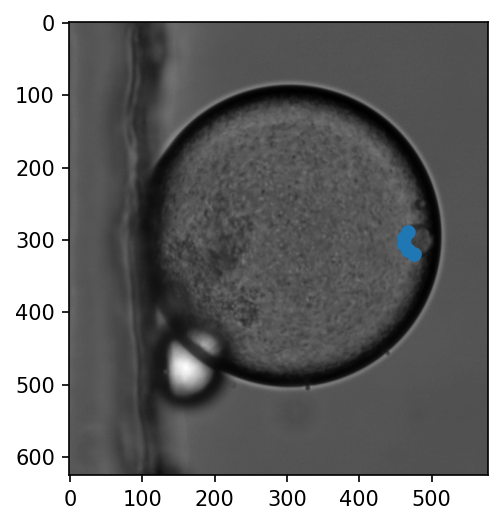

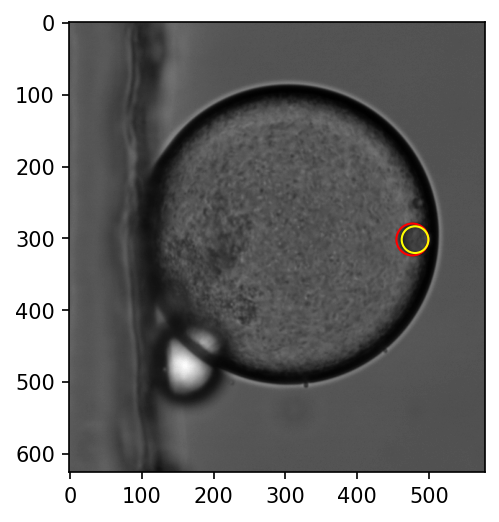

In [38]:
# single frame
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\05"
img_folder = r"D:\DE\06012022\05\8-bit"
frame = 7000
raw_img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(frame)))
inner_traj = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1l.csv")).set_index("frame")
x0, y0, r0 = inner_traj.x.loc[frame], inner_traj.y.loc[frame], inner_traj.r.loc[frame]
original_circle = {"x": x0, "y": y0, "r": r0}
corrected_circle = subpixel_correction(original_circle, raw_img, plot=True, **params)
fig = plt.figure(figsize=(3, 3), dpi=150)
ax = fig.add_axes([0,0,1,1])
ax.imshow(raw_img, cmap="gray")
cobj = mpatch.Circle((original_circle["x"], original_circle["y"]), original_circle["r"], fill=False, ec="red", lw=1)
ax.add_patch(cobj)
ccor = mpatch.Circle((corrected_circle["x"], corrected_circle["y"]), corrected_circle["r"], fill=False, ec="yellow", lw=1)
ax.add_patch(ccor)

oq = circle_quality_std(raw_img, original_circle)
cq = circle_quality_std(raw_img, corrected_circle)
print("oq: {0:.2f}, cq: {1:.2f}".format(oq, cq))

### 0.3 Correction report

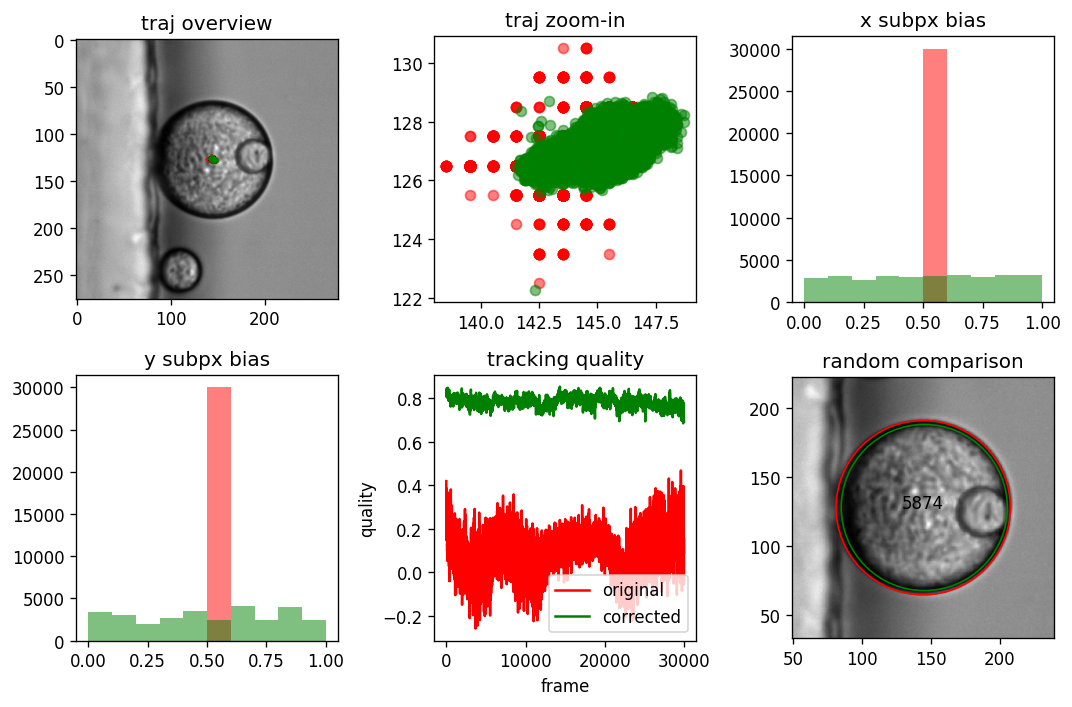

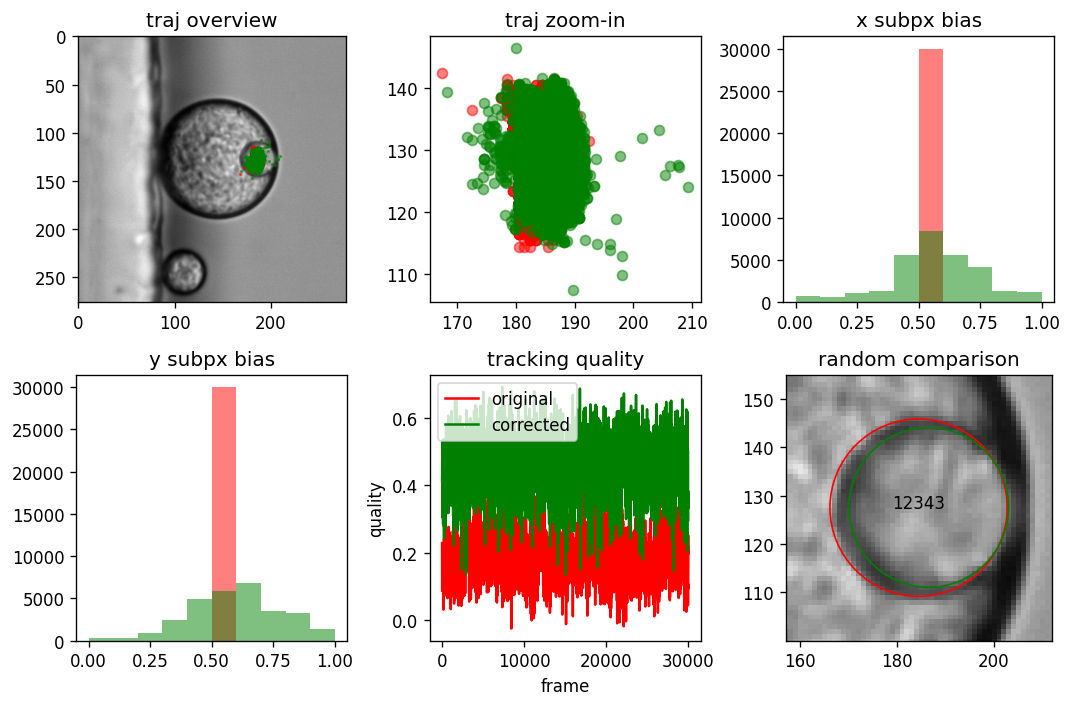

In [73]:
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\03"
img_folder = r"D:\DE\06012022\03\8-bit"
for tname in ["t0", "t1"]:
    original_traj = pd.read_csv(os.path.join(analysis_folder, "fulltraj_{}l.csv".format(tname))).set_index("frame")
    corrected_traj = pd.read_csv(os.path.join(analysis_folder, "fulltraj_{}lc.csv".format(tname))).set_index("frame")
    generate_correction_report(original_traj, corrected_traj, img_folder, analysis_folder, 
                               report_name="correction-report-{}.jpg".format(tname))

### 0.4 Subtraction

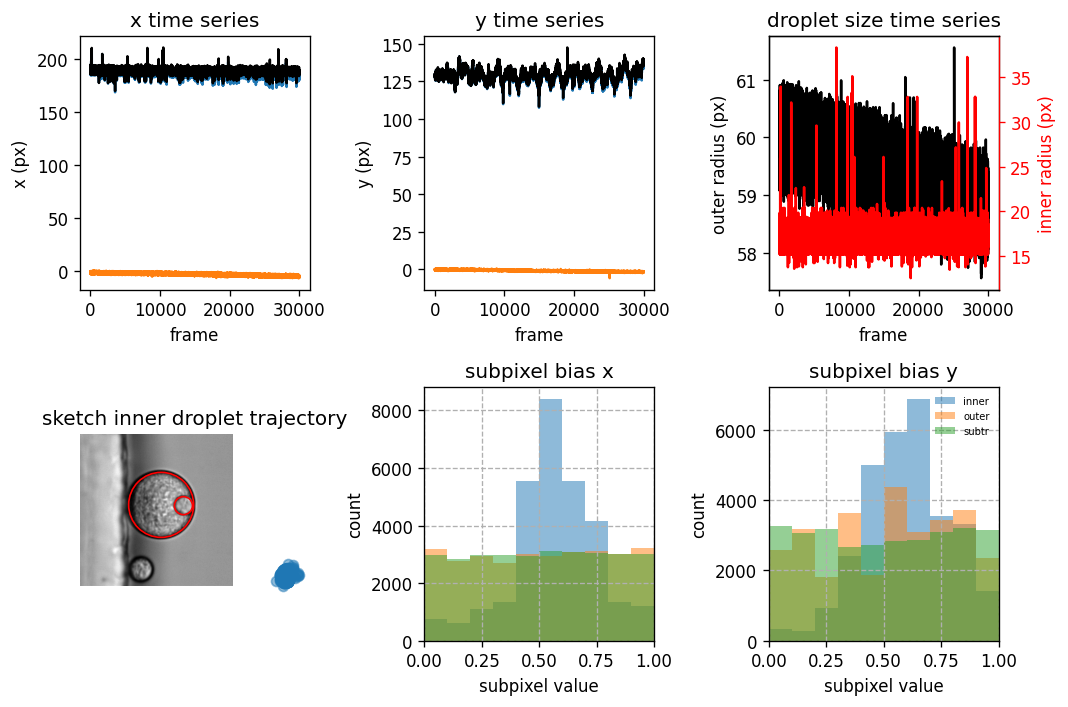

In [2]:
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\03"
img_folder = r"D:\DE\06012022\03\8-bit"
subtraction_report(analysis_folder, img_folder)

### 0.5 Batch tracking

<font color="red"> Do NOT run the following block unless you know what you are doing! In most cases, it should be moved to a *.py file before executed. </font>

In [13]:
for i in range(1, 9):
    af = r"C:\Users\liuzy\Documents\06022022\Analysis\{:02d}".format(i)
    img_folder = r"D:\DE\06022022\{:02d}\8-bit".format(i)
    os.system("python tracking.py {} {}".format(af, img_folder))

### 0.6 Generate pictures for poster

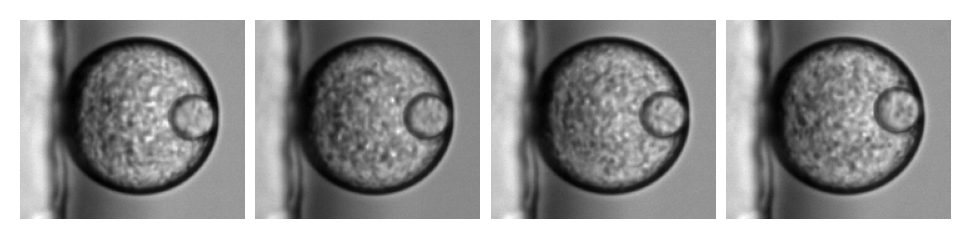

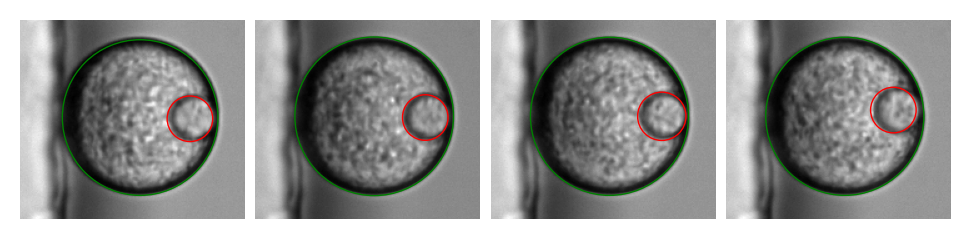

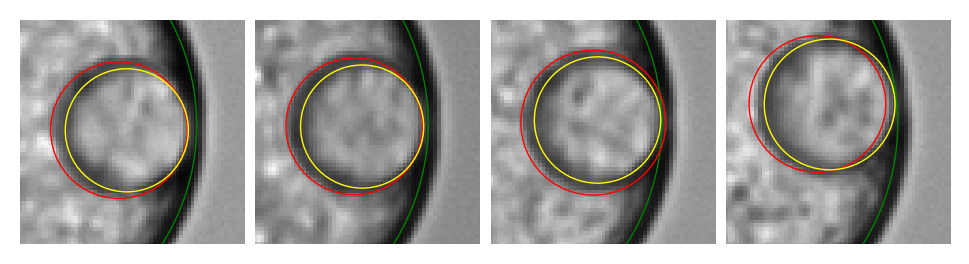

In [9]:
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\03"
img_folder = r"D:\DE\06012022\03\8-bit"
original_traj0 = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t0l.csv")).set_index("frame")
original_traj1 = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1l.csv")).set_index("frame")
corrected_traj0 = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t0lc.csv")).set_index("frame")
corrected_traj1 = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1lc.csv")).set_index("frame")
fig, ax = plt.subplots(1, 4, dpi=200, gridspec_kw={"wspace":0.05})
for i in range(0, 4):
    frame = i * 1000
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(frame)))
    ax[i].imshow(img, cmap="gray")
    ax[i].axis("off")
    ax[i].set_xlim([50, 230])
    ax[i].set_ylim([210, 50])


fig, ax = plt.subplots(1, 4, dpi=200, gridspec_kw={"wspace":0.05})
for i in range(0, 4):
    frame = i * 1000
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(frame)))
    ax[i].imshow(img, cmap="gray")
    ax[i].axis("off")
    # show inner tracking
    circ = mpatch.Circle((original_traj0.x.loc[frame], original_traj0.y.loc[frame]), original_traj0.r.loc[frame],
                        fill=False, color="green", lw=.5)
    ax[i].add_patch(circ)
    # show outer tracking
    circ1 = mpatch.Circle((original_traj1.x.loc[frame], original_traj1.y.loc[frame]), original_traj1.r.loc[frame],
                        fill=False, color="red", lw=.5)
    ax[i].add_patch(circ1)
    ax[i].set_xlim([50, 230])
    ax[i].set_ylim([210, 50])
    
fig, ax = plt.subplots(1, 4, dpi=200, gridspec_kw={"wspace":0.05})
for i in range(0, 4):
    frame = i * 1000
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(frame)))
    ax[i].imshow(img, cmap="gray")
    ax[i].axis("off")
    # show inner tracking
    circ = mpatch.Circle((corrected_traj0.x.loc[frame], corrected_traj0.y.loc[frame]), corrected_traj0.r.loc[frame],
                        fill=False, color="green", lw=.5)
    ax[i].add_patch(circ)
    # show outer tracking
    
    circ1 = mpatch.Circle((original_traj1.x.loc[frame], original_traj1.y.loc[frame]), original_traj1.r.loc[frame],
                        fill=False, color="red", lw=.5)
    ax[i].add_patch(circ1)
    # show corrected tracking
    ct = subpixel_correction({"x": original_traj1.x.loc[frame], 
                              "y": original_traj1.y.loc[frame], 
                              "r": original_traj1.r.loc[frame]}, img, range_factor=0.2, 
                              sample=4, sample_range=(1.57, 4.71), method="minimum", plot=False)
    circ1c = mpatch.Circle((ct["x"], ct["y"]), ct["r"], fill=False, color="yellow", lw=.5)
    ax[i].add_patch(circ1c)
    ax[i].set_xlim([160, 220])
    ax[i].set_ylim([160, 100])

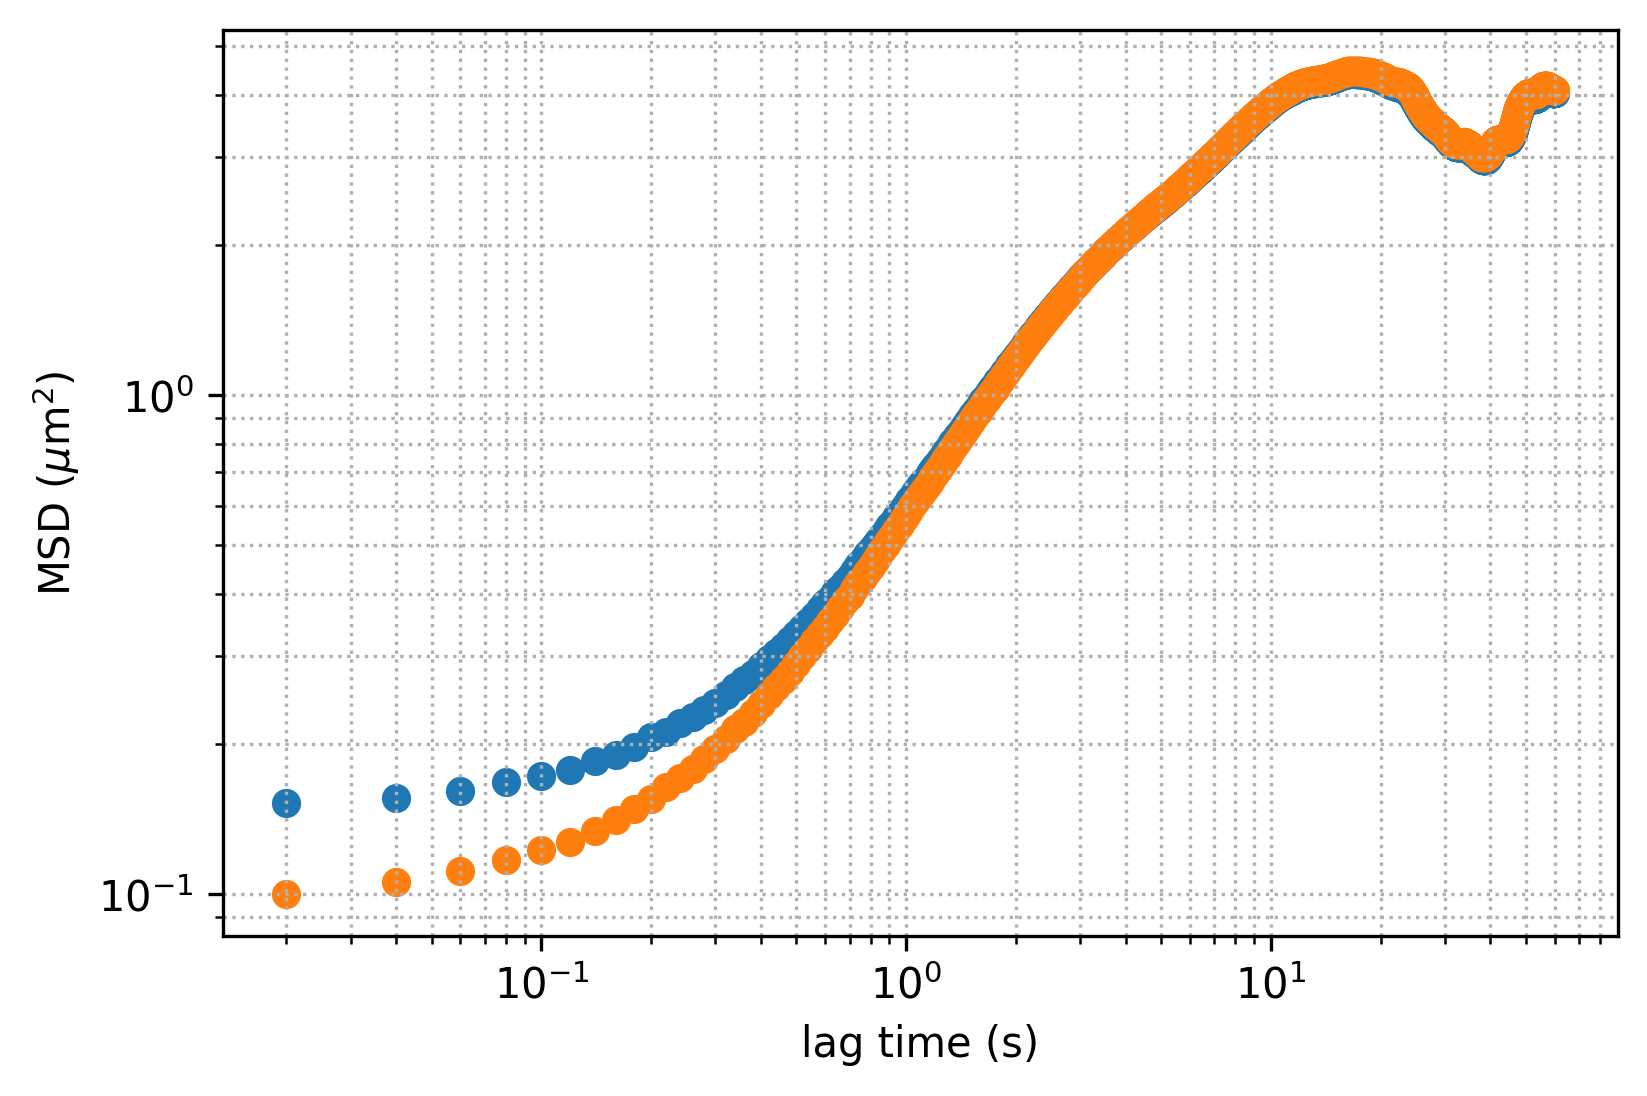

In [15]:
# MSD
MPP = 0.33
FPS = 50
t1 = original_traj1.reset_index()
t2 = corrected_traj1.reset_index()
# t1.y = gaussian_filter1d(t1.y, sigma=9/4)
# t2.y = gaussian_filter1d(t2.y, sigma=9/4)
plt.figure(dpi=300)
msdo = tp.msd(t1, mpp=MPP, fps=FPS, max_lagtime=3000)
plt.scatter(msdo.lagt, msdo["<y^2>"])
msdc = tp.msd(t2, mpp=MPP, fps=FPS, max_lagtime=3000)
plt.scatter(msdc.lagt, msdc["<y^2>"])

# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.xlabel("lag time (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

(50.0, 230.0, 210.0, 50.0)

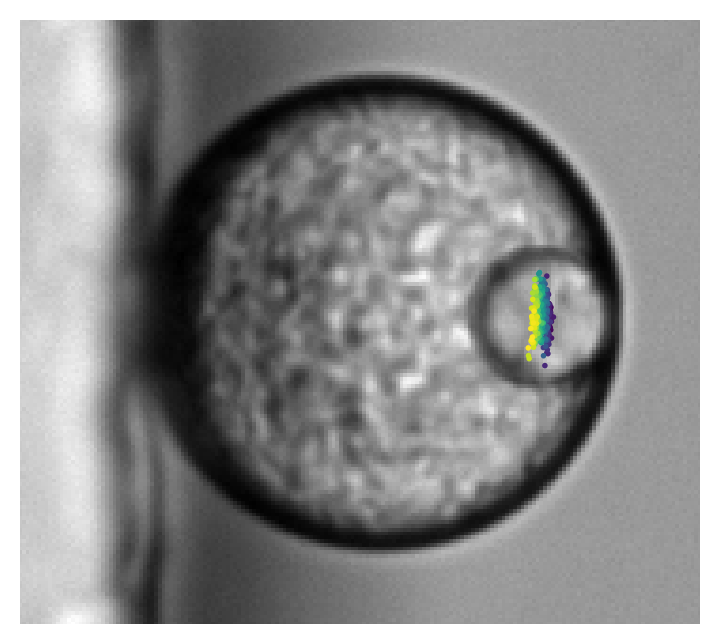

In [72]:
# traj
fig, ax = plt.subplots(dpi=200)
img = io.imread(os.path.join(img_folder, "00000.tif"))
ax.imshow(img, cmap="gray")
ax.set_xlim([50, 230])
ax.set_ylim([210, 50])
# ax.scatter(original_traj1[::100].x, original_traj1[::100].y, 
#             c="red", s=1)
ax.scatter(corrected_traj1[::100].x, corrected_traj1[::100].y, 
            c=corrected_traj1[::100].index, s=1)
ax.axis("off")

Text(0, 0.5, 'detected radius (px)')

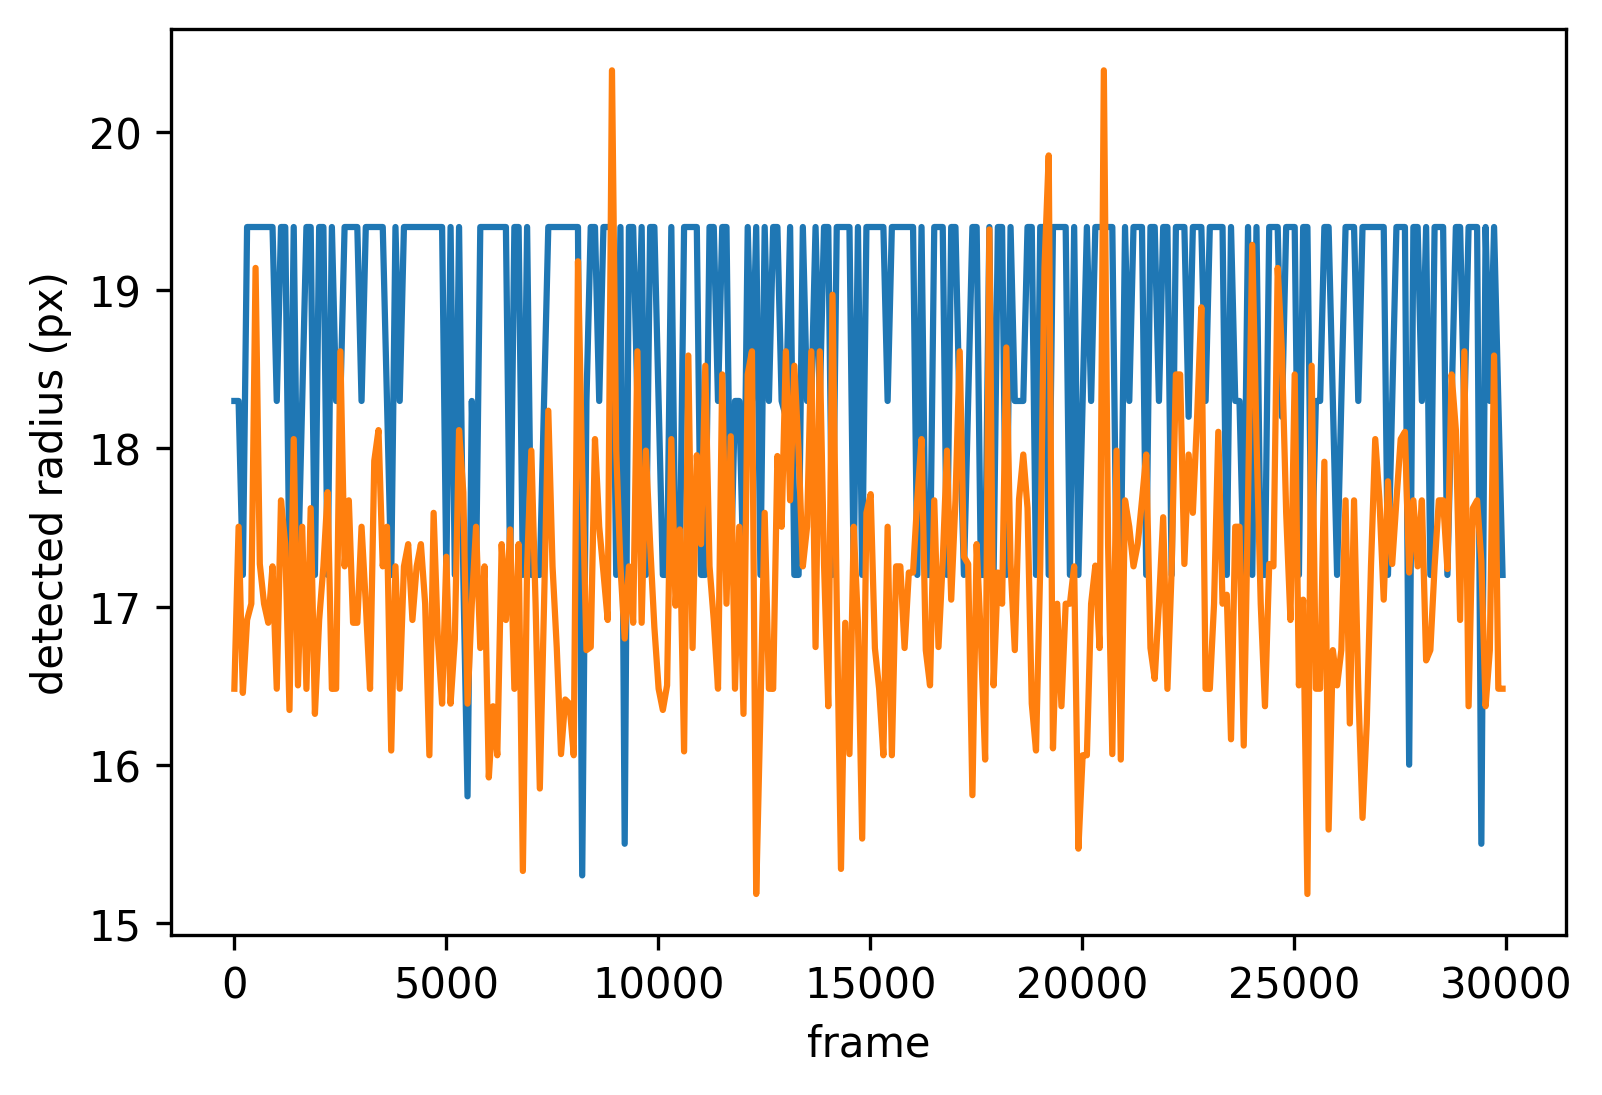

In [109]:
# radius time series

plt.figure(dpi=300)
t1 = original_traj1.reset_index()[::100]
t2 = corrected_traj1.reset_index()[::100]
plt.plot(t1.frame, t1.r)
plt.plot(t2.frame, t2.r)
plt.xlabel("frame")
plt.ylabel("detected radius (px)")

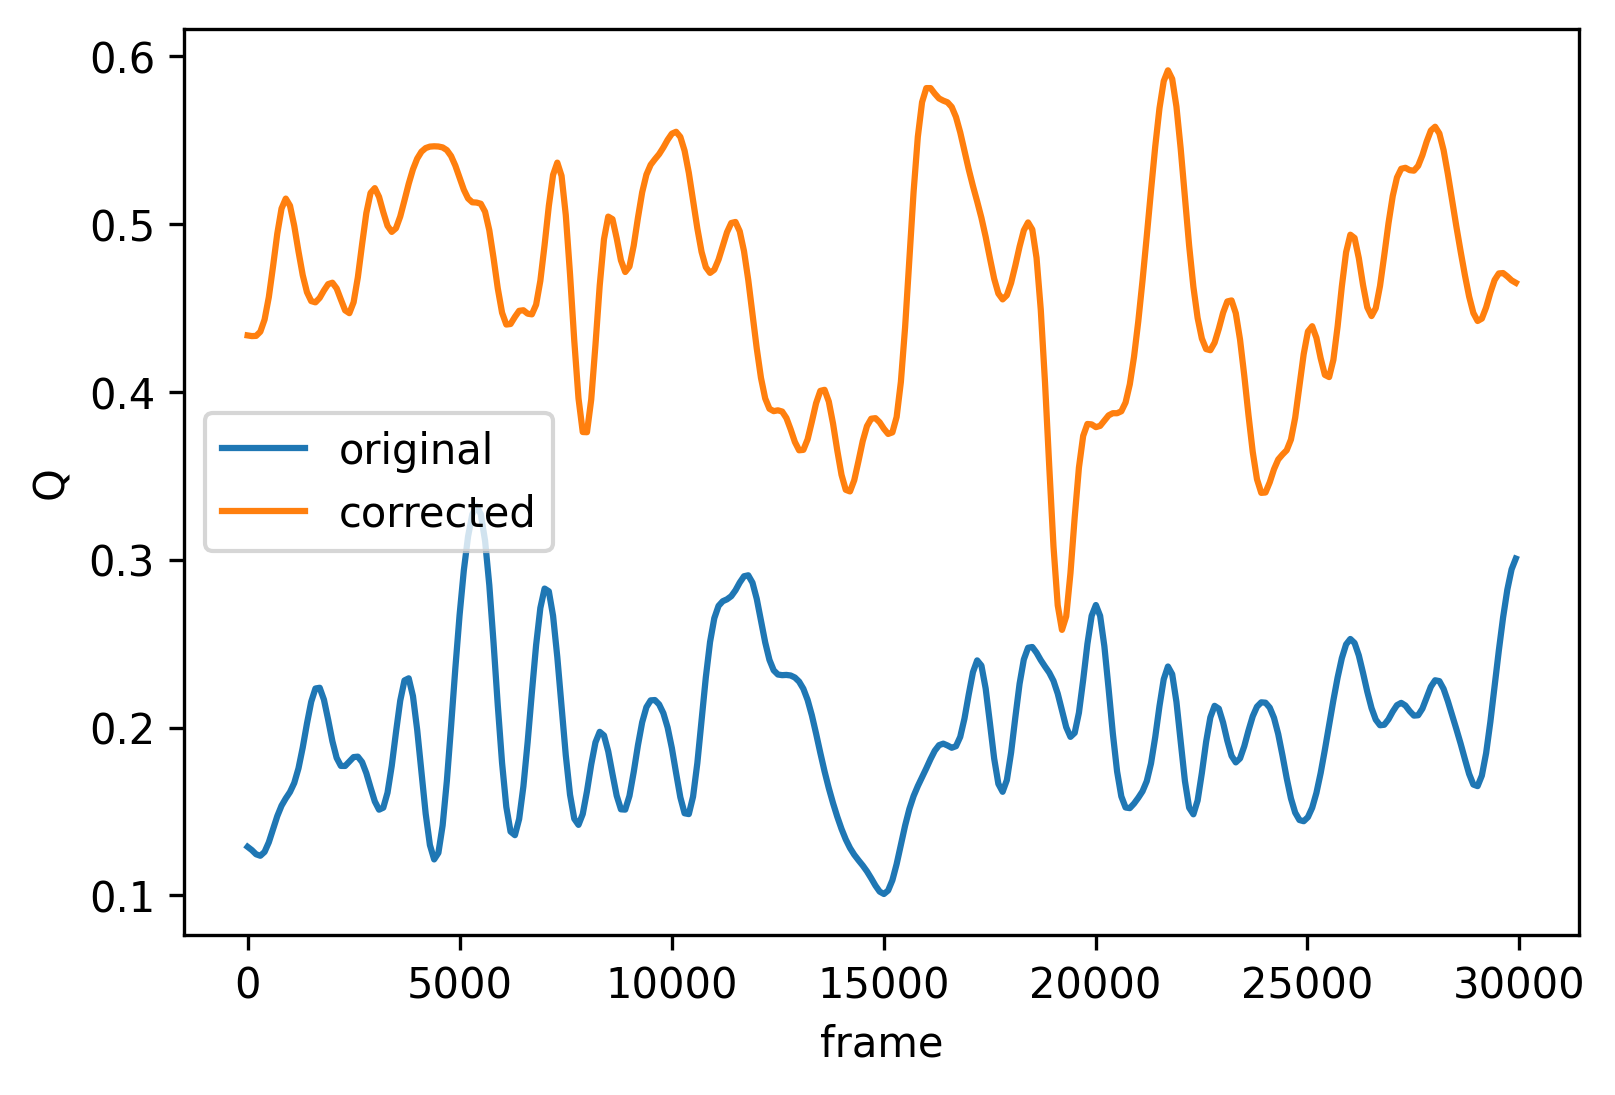

In [110]:
# quality time series

plt.figure(dpi=300)
t1 = original_traj1.reset_index()[::100]
t2 = corrected_traj1.reset_index()[::100]
plt.plot(t2.frame, gaussian_filter1d(t2.original_quality, 3), label="original")
plt.plot(t2.frame, gaussian_filter1d(t2.corrected_quality, 3), label="corrected")
plt.xlabel("frame")
plt.ylabel("Q")
plt.legend()

#### Improved MSD

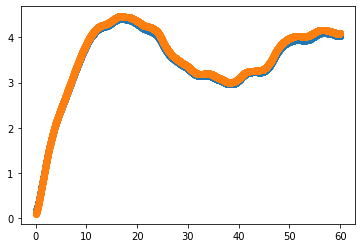

In [11]:
t1 = original_traj1.reset_index()
t2 = corrected_traj1.reset_index()

msd1 = tp.msd(t1, mpp=0.33, fps=50, max_lagtime=3000)
msd2 = tp.msd(t2, mpp=0.33, fps=50, max_lagtime=3000)

plt.scatter(msd1.lagt, msd1["<y^2>"])
plt.scatter(msd2.lagt, msd2["<y^2>"])

In [ ]:
msd = 

## 1 Whole image tracking and multiple detections per frame

Although I know that I only want to track one droplet, and the current code will only return the best circle (the highest score feature in the accumulator) due to the large `minDist` setting, sometimes the droplet I want to track is not the best circle. 

If we track multiple circles in an image, and then use the `link` function in tracking analysis, we might be able to detect the droplets in more frames.

In this scheme, since we won't know which circle is the actual droplet we are looking for, using the position of frame 1 to crop frame 2 is not a good idea. Therefore, we run the circle detection on full images.

In [331]:
folder = r'C:\Users\liuzy\Documents\06022022'
n = 1
l = readdata(os.path.join(folder, '{:02d}'.format(n)), 'tif')
num_images = len(l)
print('Total {:d} frames'.format(num_images))

Total 600 frames


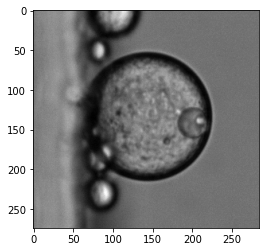

In [332]:
# show image 1 and manually crop
img = io.imread(l.Dir[0])
plt.imshow(img, cmap='gray')

<font color='red'> Set `Hough_maxRadius` and `Hough_minRadius`, in cases where no circle can be detected or the circle detected is way off, modify `Hough_dp`  

circles detected:  2
Wall time: 16.9 ms


array([[190.5, 134.5,  18.1],
       [100.5,   3.5,  18.1]], dtype=float32)

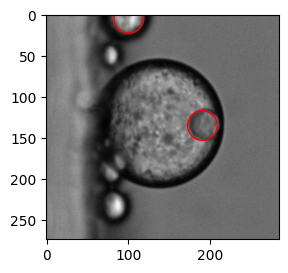

In [337]:
%%time
# test HoughCircles params


params_init = {"dp"       : 1    , 
               "minDist"  :  100,
               "param1"   :  150   , 
               "param2"   :  15, 
               "maxRadius":  22,
               "minRadius":  15}
# Hough_minDist_init = params_init["maxRadius"]
# circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, Hough_dp_init, Hough_minDist_init, param1=Hough_param1_init,
#                                param2=Hough_param2_init, maxRadius=Hough_maxRadius_init, minRadius=Hough_minRadius_init)
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, **params_init)

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.imshow(img, cmap='gray')
for circle in circles[0][:5]:
    circle_object = mpatch.Circle((circle[0], circle[1]), circle[2],
                                 fill=False, ec='red', lw=1)
    ax.add_patch(circle_object)
print("circles detected: ", circles.shape[1])
circles[0][:5]

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

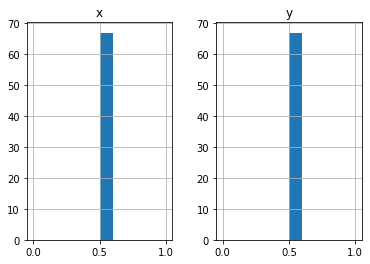

In [338]:
# Initial params
save_step = 100 # save detection overlay image every save_step steps, int
number_of_circles = 3 # number of circles to be detected, the idea is to detect multiple circles and use linking criteria to filter out false detection
start_frame = 0
end_frame = None
img_list = l.reset_index()
num_images = len(img_list)

# HoughCircles params
params = params_init

# initialize result containers
x_list = [] # x of circle
y_list = [] # y of circle
filename_list = [] # filename of raw image
nc_list = [] # number of circles detected in each frame
data_list = []

# initialize output folder
main_output_folder = os.path.join(folder, 'Analysis', '{:02d}'.format(n))
cropped_folder = os.path.join(main_output_folder, 'cropped')
if os.path.exists(main_output_folder) == False:
    os.makedirs(main_output_folder)
if os.path.exists(cropped_folder) == False:
    os.makedirs(cropped_folder)


t0 = time.monotonic()
count = 1
for num, i in img_list[::20].iterrows():
    if num < start_frame:
        continue
    # read image and convert to 8-bit (HoughCircles requires 8-bit images)
    
    img = to8bit(io.imread(i.Dir))
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(img, cmap='gray')
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, **params)
    
    if circles is not None: # check if any circle is detected        
        for circle in circles[0][:number_of_circles]:            
            data_item = pd.DataFrame({"x": circle[0], 
                                      "y": circle[1], 
                                      "r": circle[2],
                                      "filename": i.Name}, index=[0])
            data_list.append(data_item)       
            circle_object = mpatch.Circle((circle[0], circle[1]), circle[2],
                                     fill=False, ec='red', lw=1)
            ax.add_patch(circle_object)  
    else:
        # if no circle is detected, set x, y to NaN
        # x, y = np.nan, np.nan
        data_item = pd.DataFrame({"x": np.nan, 
                                  "y": np.nan, 
                                  "r": np.nan,
                                  "filename": i.Name}, index=[0])
        data_list.append(data_item)

    if num % save_step == 0: # save image and detecting result for validating purpose
        fig.savefig(os.path.join(cropped_folder, '{}.jpg'.format(i.Name)))
    plt.pause(0.01)
    plt.close() # prevent figure from showing up inline
    show_progress((num+1)/num_images)
    t1 = time.monotonic()-t0
    print("time: {0:.1f} s | processing speed: {1:.1f} frame/s".format(t1, count/t1))
    count += 1
    clear_output(wait=True)

    data = pd.concat(data_list, axis=0)

# save traj data in a *.csv file
data.to_csv(os.path.join(main_output_folder, 'traj.csv'), index=False)
# save HoughCircles params in a *.json file for future ref
with open(os.path.join(main_output_folder, "hough_params.json"), "w") as f:
    f.write(json.dumps(params))
# show the subpixel bias analysis
tp.subpx_bias(data)

### Link droplet trajectory

In [177]:
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\00"
img_folder = r"D:\DE\06012022\00\8-bit"
traj = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1.csv"))
# traj = data.assign(frame=data.filename.astype("int")//50)

In [178]:
t = tp.link(traj, 30, memory=5)

Frame 29999: 3 trajectories present.


In [179]:
t1 = tp.filter_stubs(t, 500)

In [35]:
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\04"
img_folder = r"D:\DE\06012022\04\8-bit"
t1 = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1l.csv"))

([<matplotlib.axis.XTick at 0x20d25b2a910>], [Text(0, 0, '')])

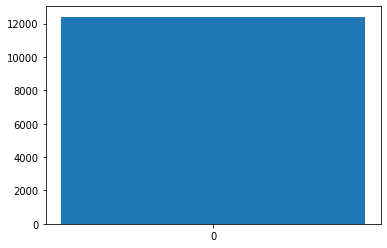

In [36]:
# particle number histogram
count_list = []
for _, g in t1.groupby("particle"):
    count_list.append(len(g))
plt.bar(t1.particle.drop_duplicates().astype("string"), count_list)
plt.xticks(t1.particle.drop_duplicates().astype("string"))

In [38]:
t1

x      y     r  frame  particle
0      375.5  393.5  34.4   4723         0
1      376.5  393.5  34.4   4724         0
2      374.5  393.5  34.4   4725         0
3      374.5  393.5  34.4   4726         0
4      375.5  392.5  34.4   4727         0
...      ...    ...   ...    ...       ...
12408  476.5  292.5  34.4  24818         0
12409  476.5  294.5  34.4  24819         0
12410  476.5  292.5  34.4  24825         0
12411  475.5  293.5  34.4  24826         0
12412  475.5  293.5  34.4  24828         0

[12413 rows x 5 columns]

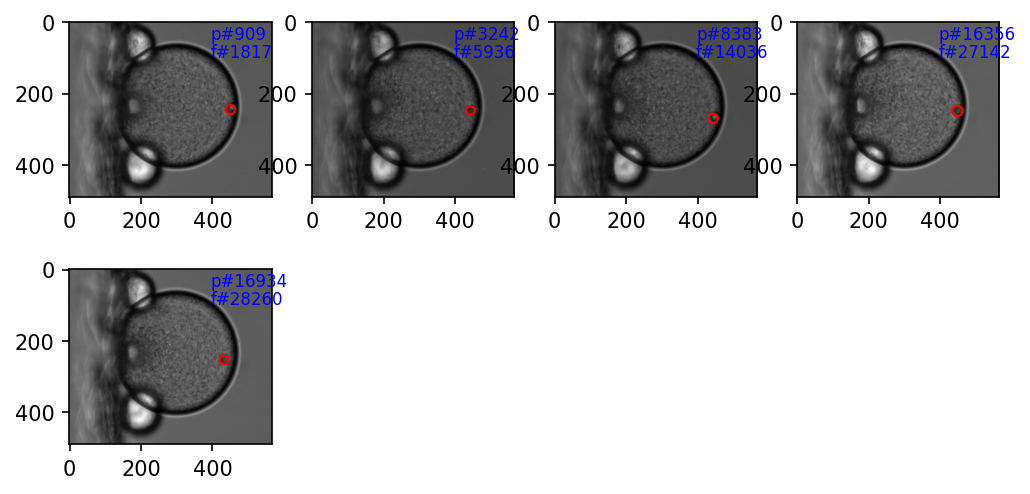

In [309]:
# check which particle is True inner droplet and which is false detection
n_images = len(t1.particle.drop_duplicates())
ncols = 4
nrows = n_images // ncols
if n_images % ncols != 0:
    nrows += 1
fig = plt.figure(figsize=(2*ncols, 2*nrows), dpi=150)
count = 1
for particle in t1.particle.drop_duplicates():
    sub_traj = t1.loc[t1.particle==particle]
    ax = fig.add_subplot(nrows, ncols, count)
    count += 1
    for num, i in sub_traj.iterrows():   
        img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(int(i.frame))))
        ax.imshow(img, cmap="gray")
        circle_object = mpatch.Circle((i.x, i.y), i.r, 
                                     fill=False, ec='red', lw=1)
        ax.add_patch(circle_object)
        ax.annotate("p#{:d}".format(particle), (0.7, 0.9), xycoords="axes fraction", color="blue", fontsize=8)
        ax.annotate("f#{:d}".format(int(i.frame)), (0.7, 0.8), xycoords="axes fraction", color="blue", fontsize=8)
#         plt.pause(0.1)
#         plt.close()
        break

In [298]:
t1 = t1.query("particle not in [5525, 5885, 7083, 7798, 8228, 8765, 9931]")

In [301]:
# print duplicated frames (frames with more than 1 particles)
dup = pd.concat(g for _, g in t1.drop(columns="frame").groupby("frame") if len(g) > 1)
dup.head()

KeyError: 'frame'

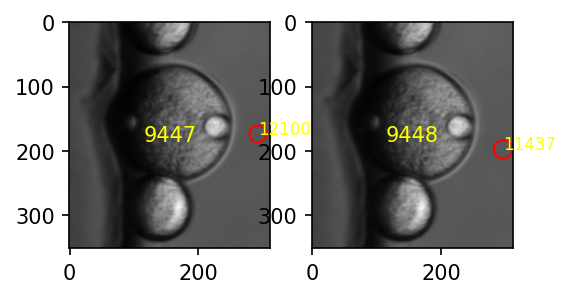

In [237]:
# plot duplicates
img_folder = r"D:\DE\06012022\01\8-bit"
n_images = len(dup.index.drop_duplicates())
ncols = 4
nrows = n_images // ncols
if n_images % ncols != 0:
    nrows += 1
fig = plt.figure(figsize=(2*ncols, 2*nrows), dpi=150)
count = 1

for filename in dup.index.drop_duplicates():
    ax = fig.add_subplot(nrows, ncols, count)
    count += 1
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(int(filename))))
    subdata = dup.loc[dup.index==filename]
    ax.imshow(img, cmap="gray")
    for num, i in subdata.iterrows():
        circle_object = mpatch.Circle((i.x, i.y), i.r, fill=False, ec="red", lw=1)
        ax.add_patch(circle_object)
        ax.annotate("{:d}".format(int(i.particle)), (i.x, i.y), color="yellow", fontsize=8)
        ax.annotate("{:d}".format(int(num)), (0.5, 0.5), 
                    color="yellow", xycoords="axes fraction",
                    verticalalignment="center", horizontalalignment="center")

In [311]:
t1.to_csv(os.path.join(analysis_folder, "fulltraj_t1l.csv"), index=False)

In [166]:
t1.to_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t.csv"), index=False)

In [145]:
t1.frame *= 50

C:\Users\liuzy\Miniconda3\lib\site-packages\pandas\core\generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [310]:
t1.particle = 0

In [284]:
t1

x      y     r  frame  particle
646    479.5  291.5  24.4    755       233
650    478.5  291.5  22.2    758       233
653    474.5  290.5  19.1    760       233
656    477.5  290.5  22.1    762       233
658    477.5  288.5  21.3    763       233
...      ...    ...   ...    ...       ...
54346  473.5  309.5  21.1  29995       233
54347  476.5  310.5  24.4  29996       233
54348  474.5  310.5  22.2  29997       233
54349  474.5  310.5  22.2  29998       233
54350  473.5  311.5  22.2  29999       233

[29131 rows x 5 columns]

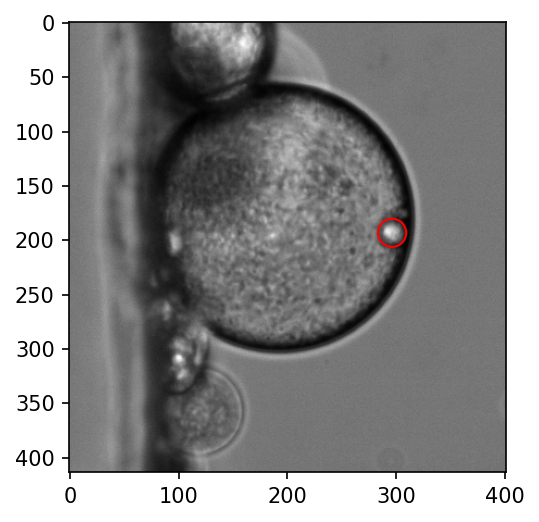

In [218]:
# verify tracking quality
analysis_folder = r"C:\Users\liuzy\Documents\05312022\Analysis\02"
img_folder = r"D:\DE\05312022\02\8-bit"
t1 = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1lc.csv")).set_index("frame")
for frame, i in t1[::100].iterrows():
    fig = plt.figure(figsize=(3, 3), dpi=150)
    ax = fig.add_axes([0,0,1,1])
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(int(frame))))
    ax.imshow(img, cmap="gray")
    circle_object = mpatch.Circle((i.x, i.y), i.r, fill=False, ec="red", lw=1)
    ax.add_patch(circle_object)
    plt.pause(0.1)
    
    clear_output(wait=True)

### Compare two trackings

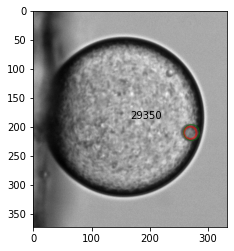

In [175]:
# Compare two trackings
folder = r"C:\Users\liuzy\Documents\05312022"
n = 6
traj1 = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), 
                                 "t.csv")).set_index("frame")
traj2 = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), 
                                 "t1c.csv")).set_index("frame")
traj1.index = traj1.index.astype("int")
traj2.index = traj2.index.astype("int")
combine_traj = pd.concat([traj1, traj2], axis=1, keys=["traj1", "traj2"])

for num, i in combine_traj.iterrows():
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([0,0,1,1])
    img = io.imread(os.path.join(folder, "{:02d}".format(n), "{:05d}.tif".format(num)))
    ax.imshow(img, cmap="gray")
    c1 = mpatch.Circle((i["traj1"].x, i["traj1"].y), i["traj1"].r, 
                       fill=False, ec="red", lw=2, alpha=0.5)
    c2 = mpatch.Circle((i["traj2"].x, i["traj2"].y), i["traj2"].r, 
                       fill=False, ec="green", lw=1, alpha=0.5)
    ax.annotate("{:05d}".format(int(num)), (0.5, 0.5), xycoords="axes fraction")
    ax.add_patch(c1)
    ax.add_patch(c2)
    plt.pause(.01)
    plt.close()
    clear_output(wait=True)
#     if num == 0:
#         break

### Overview of the tracking results

This section provides an overview of the tracking, to see if the quality is satisfactory. This will include:
1. x time series: inner, outer, subtraction
2. y time series: inner, outer, subtraction
3. droplet size time series: outer and inner
4. sketch of inner droplet trajectory
5. subpixel bias: x, y, subtraction

In [64]:
outer_traj.sample().x.values[0]

-6.520288998599213

## 2 Subpixel accuracy

The Hough Circles algorithm works well in detecting circle objects in images. However, the accuracy in this implementation is not great, as the position resolution is only 1 pixel (all the positions of circles detected are xx.5). 

### 2.1 Cross-boundary Gaussian fitting (and local minimum correction)

A possible way to achieve subpixel accuracy is to find maxima in cross-boundary intensity profiles and modify the original detected position. 

Here, we want to design a function, which takes in the original circle detection information (x0, y0, r0), as well as the raw image, and use cross-boundary intensity profile fitting to return a corrected circle detection (x1, y1, r1).

oq: 0.15, cq: 0.62


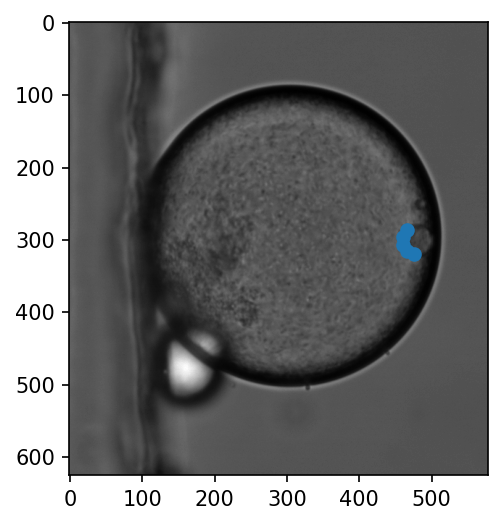

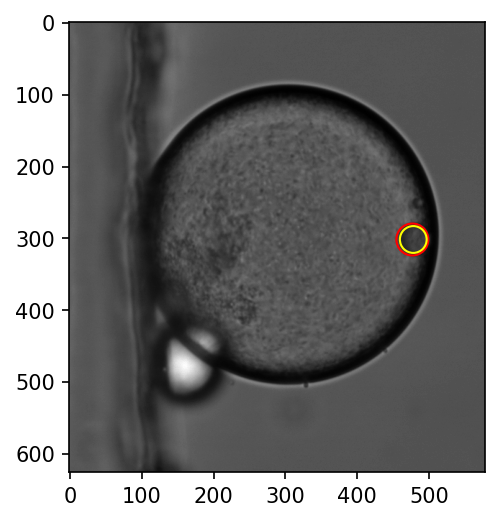

In [50]:
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\05"
img_folder = r"D:\DE\06012022\05\8-bit"
frame = 7000
raw_img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(frame)))
inner_traj = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1l.csv")).set_index("frame")
x0, y0, r0 = inner_traj.x.loc[frame], inner_traj.y.loc[frame], inner_traj.r.loc[frame]
original_circle = {"x": x0, "y": y0, "r": r0}
corrected_circle = subpixel_correction(original_circle, raw_img, range_factor=0.2, 
                                         plot=True, thres=10, method="minimum", sample=5, sample_range=(np.pi/2, 3/2*np.pi))
fig = plt.figure(figsize=(3, 3), dpi=150)
ax = fig.add_axes([0,0,1,1])
ax.imshow(raw_img, cmap="gray")
cobj = mpatch.Circle((original_circle["x"], original_circle["y"]), original_circle["r"], fill=False, ec="red", lw=1)
ax.add_patch(cobj)
ccor = mpatch.Circle((corrected_circle["x"], corrected_circle["y"]), corrected_circle["r"], fill=False, ec="yellow", lw=1)
ax.add_patch(ccor)

oq = circle_quality_std(raw_img, original_circle)
cq = circle_quality_std(raw_img, corrected_circle)
print("oq: {0:.2f}, cq: {1:.2f}".format(oq, cq))

### 2.2 Compare circle detection quality

We need a metric of circle detection quality. An intuitive metric is the standard deviation of boundary pixel intensities. A good circle should have smaller variation in boundary pixel intensities, hence smaller standard deviation.

In [20]:
folder = r"C:\Users\liuzy\Documents\06032022"
n = 0
raw_img = io.imread(os.path.join(folder, "{:02d}".format(n), "00000.tif"))
inner_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "traj1.csv"))
x0, y0, r0 = inner_traj.x.iloc[0], inner_traj.y.iloc[0], inner_traj.r.iloc[0]
original_circle = {"x": x0, "y": y0, "r": r0}
corrected_circle = subpixel_correction(original_circle, raw_img, range_factor=0.2, plot=False, thres=10, method="minimum")

circle radius: 14.7
distsq threshold: 10
number of pixels on circle: 61
std circle: 23.57
std img: 35.58
quality original: -0.15
quality: 0.34


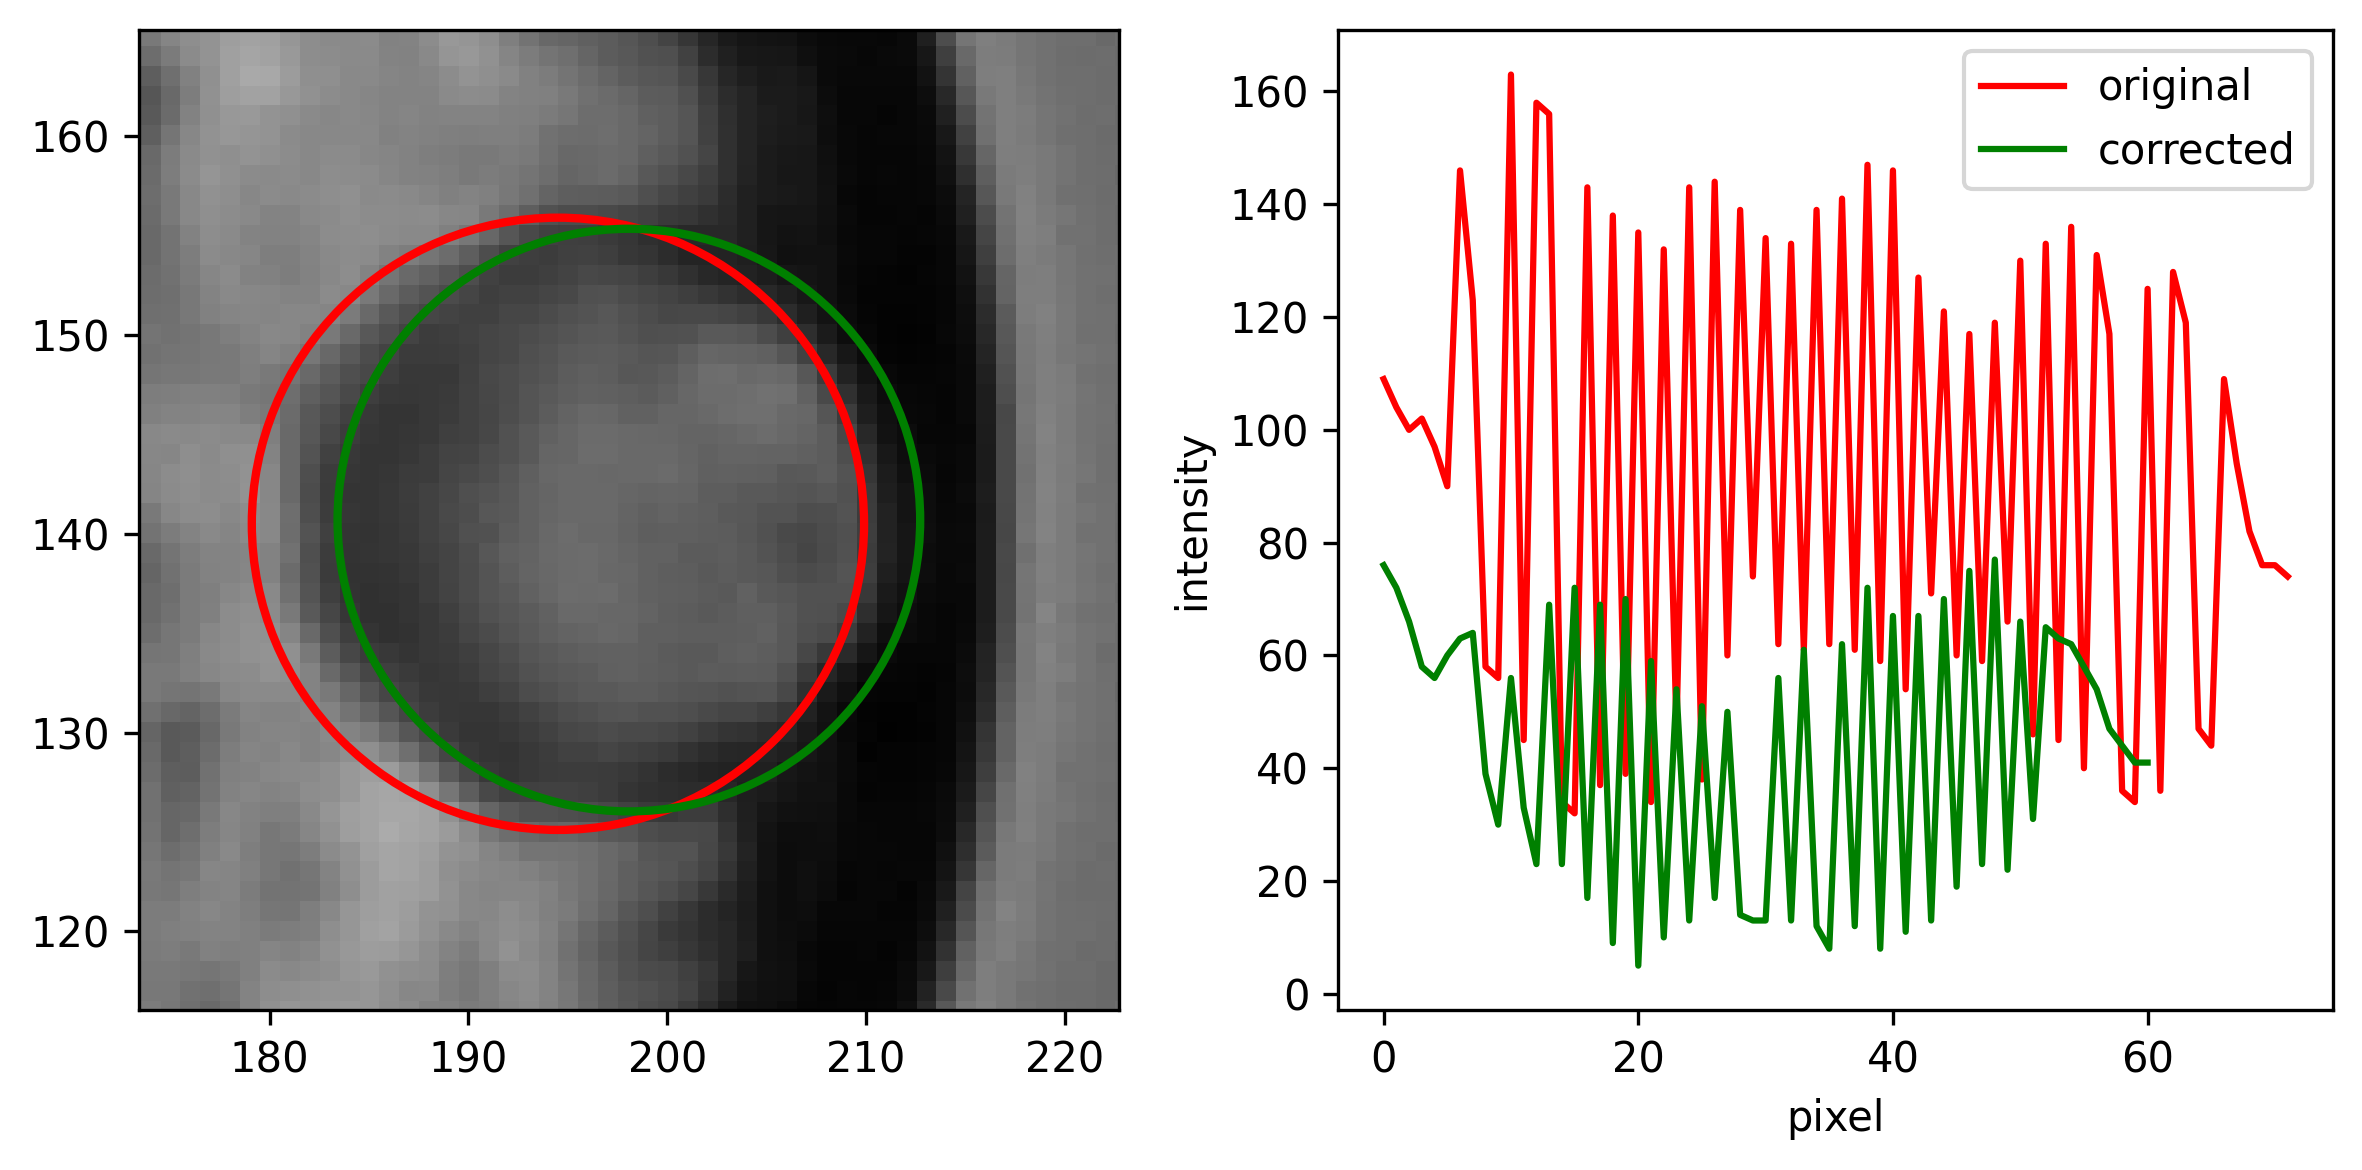

In [21]:
# get all the pixel coords on the circle
x0, y0, r0 = original_circle["x"], original_circle["y"], original_circle["r"]
x, y, r = corrected_circle["x"], corrected_circle["y"], corrected_circle["r"]
# 1. make X, Y coordinates of all image pixels
Y, X = np.mgrid[0:raw_img.shape[0], 0:raw_img.shape[1]]
# 2. compute distance (square) matrix from each pixel to circle center
dist = (X-x) ** 2 + (Y-y) ** 2 - r ** 2 
dist_o = (X-x0) ** 2 + (Y-y0) ** 2 - r0 ** 2 
# 3. make a boolean matrix ind where the distance is smaller than 5 (note that 5 is an arbitrary number and need revision)
distsq_thres = 10
ind = abs(dist) < distsq_thres
ind_o = abs(dist_o) < distsq_thres
# 4. use the ind matrix to get all the pixel intensity values on the detected circle
original_circle_pixels = raw_img[ind_o]
circle_pixels = raw_img[ind]
# 5. compute standard deviation of circle_pixels
std = circle_pixels.std()
std_o = original_circle_pixels.std()
std_img = raw_img.std()
print("circle radius: {:.1f}".format(r))
print("distsq threshold: {:d}".format(distsq_thres))
print("number of pixels on circle: {:d}".format(len(circle_pixels)))
print("std circle: {:.2f}".format(std))
print("std img: {:.2f}".format(std_img))
print("quality original: {:.2f}".format(1-std_o/std_img))
print("quality: {:.2f}".format(1-std/std_img))
# 6. plot the process
fig = plt.figure(figsize=(8, 4), dpi=300)
ax1 = fig.add_subplot(121)
ax1.imshow(raw_img, cmap="gray")
ax1.set_xlim([x-r-10, x+r+10])
ax1.set_ylim([y-r-10, y+r+10])
cobj = mpatch.Circle((x0, y0), r0, fill=False, ec="red", lw=2)
ax1.add_patch(cobj)
ccor = mpatch.Circle((x, y), r, fill=False, ec="green", lw=2)
ax1.add_patch(ccor)
ax2 = fig.add_subplot(122)
ax2.plot(original_circle_pixels, color="red", label="original")
ax2.plot(circle_pixels, color="green", label="corrected")
ax2.legend()
ax2.set_xlabel("pixel")
ax2.set_ylabel("intensity")
plt.tight_layout()

### Try the quality metric on a whole trajectory / image sequence

This is a working section for batch traj correction.

KeyboardInterrupt: 

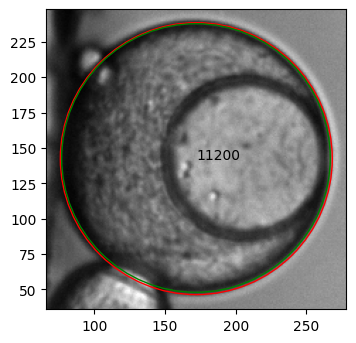

In [136]:
folder = r"C:\Users\liuzy\Documents\05312022"
n = 9
save_step = 100 # save a snapshot every save_step steps

correction_params = {"range_factor": 0.4,
                     "thres": 5,
                     "method": "minimum",
                     "plot": False, 
                     "sample": 6}

circle_list = []
original_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), 
                                         "t0.csv")).set_index("filename")
n_frames = len(original_traj)
count = 0
analysis_folder = os.path.join(folder, "Analysis", "{:02d}".format(n))
snapshot_folder = os.path.join(analysis_folder, "cropped")
if os.path.exists(snapshot_folder) == False:
    os.makedirs(snapshot_folder)
t0 = time.monotonic()
for num, i in original_traj.iterrows():
    original_circle = {"x": i.x, "y": i.y, "r": i.r}
    raw_img = io.imread(os.path.join(folder, "{:02d}".format(n), "{:05d}.tif".format(num)))
#     try:
#         corrected_circle = subpixel_correction_gaussian(original_circle, raw_img, range_factor=0.5, plot=True, thres=30)
#     except:
#         corrected_circle = original_circle
    corrected_circle = subpixel_correction(original_circle, raw_img, **correction_params)
    original_quality = circle_quality_std(raw_img, original_circle)
    corrected_quality = circle_quality_std(raw_img, corrected_circle)
    corrected_circle["frame"] = num
    corrected_circle["original_quality"] = original_quality
    corrected_circle["corrected_quality"] = corrected_quality
    circle_list.append(pd.DataFrame(corrected_circle, index=[num]))
    
    
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(raw_img, cmap="gray")
    cobj = mpatch.Circle((original_circle["x"], original_circle["y"]), original_circle["r"], fill=False, ec="red", lw=1)
    ax.add_patch(cobj)
    ccor = mpatch.Circle((corrected_circle["x"], corrected_circle["y"]), corrected_circle["r"], fill=False, ec="green", lw=1)
    ax.add_patch(ccor)
    ax.set_xlim([int(original_circle["x"]-original_circle["r"]-10), int(original_circle["x"]+original_circle["r"]+10)])
    ax.set_ylim([int(original_circle["y"]-original_circle["r"]-10), int(original_circle["y"]+original_circle["r"]+10)])
    ax.annotate(num, (0.5, 0.5), xycoords="axes fraction")    
    if count % save_step == 0:        
        fig.savefig(os.path.join(snapshot_folder, "{:05d}.jpg".format(num)))
    plt.pause(0.01)
    plt.close()
    show_progress(count / n_frames)
    t1 = time.monotonic()-t0
    print("time: {0:.1f} s | processing speed: {1:.1f} frame/s".format(t1, count/t1))
    clear_output(wait=True)    
    count += 1
corrected_traj = pd.concat(circle_list)
with open(os.path.join(analysis_folder, "correction_params.json"), "w") as f:
    f.write(json.dumps(correction_params))
corrected_traj.to_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t.csv"))

In [11]:
correction_params = {"range_factor": 0.2, 
                      "thres": 10, 
                      "method": "minimum", 
                      "plot": False, 
                      "sample_range": [-np.pi/2, np.pi*3/2]}

In [12]:
with open(os.path.join(analysis_folder, "correction_params.json"), "w") as f:
    f.write(json.dumps(correction_params))

### generate a report of the subpixel correction

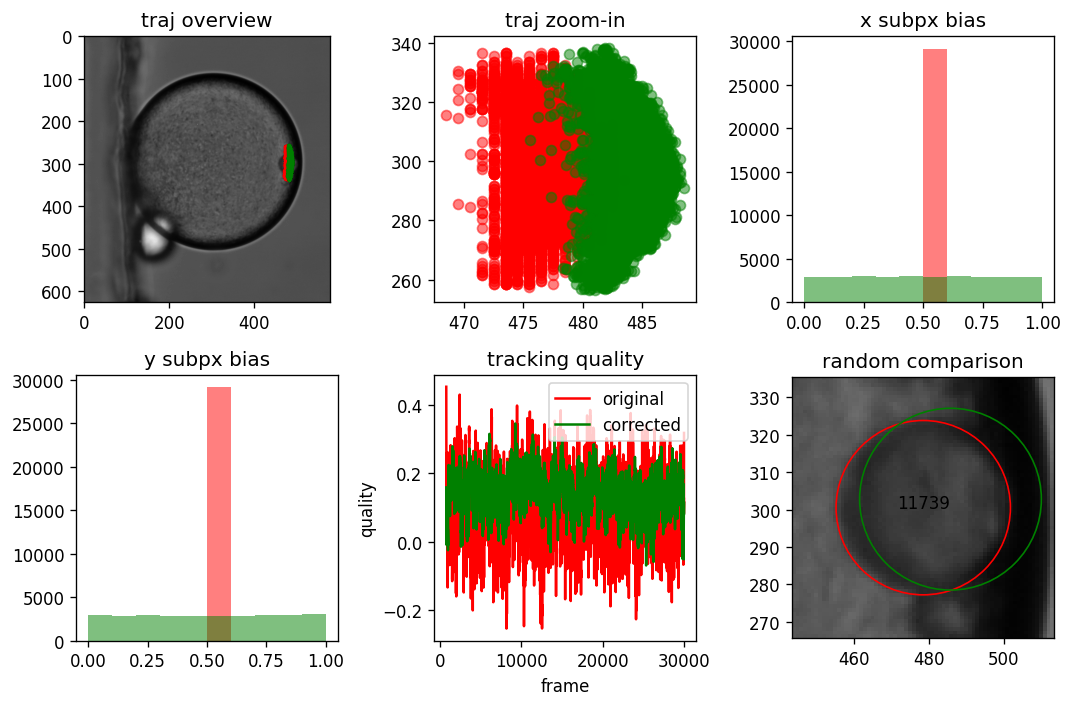

In [41]:
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\05"
original_traj = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1l.csv")).set_index("frame")
corrected_traj = pd.read_csv(os.path.join(analysis_folder, "fulltraj_t1lc.csv")).set_index("frame")
img_folder = r"D:\DE\06012022\05\8-bit"
generate_correction_report(original_traj, corrected_traj, img_folder, analysis_folder, 
                           report_name="correction-report-t1.jpg")

### 2.3 Iterative correction

Sometimes, 1 correction is not enough to give the most accurate position. In this section, we test if iteractive correction can result in better results, and most importantly, convergence. 

00 | -0.11
01 | 0.09
02 | 0.30
03 | 0.26
04 | 0.31
05 | 0.31
06 | 0.31
07 | 0.31
08 | 0.31
09 | 0.31


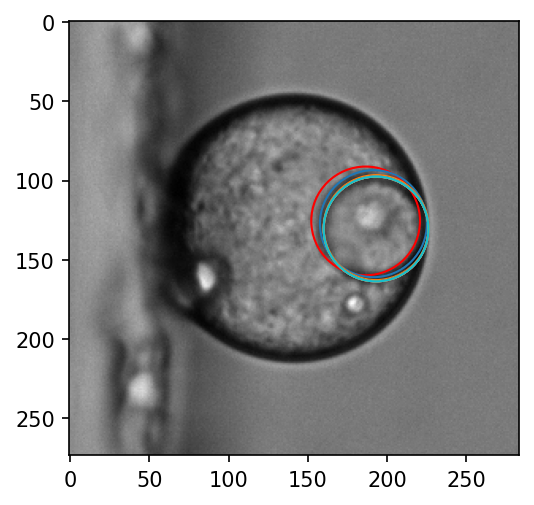

In [14]:
%matplotlib inline
folder = r"C:\Users\liuzy\Documents\06022022"
n = 2
raw_img = io.imread(os.path.join(folder, "{:02d}".format(n), "00000.tif"))
inner_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t1.csv"))
x0, y0, r0 = inner_traj.x.iloc[0], inner_traj.y.iloc[0], inner_traj.r.iloc[0]
circle = {"x": x0, "y": y0, "r": r0}
cobj = mpatch.Circle((circle["x"], circle["y"]), circle["r"], fill=False, ec="red", lw=1)
    
fig = plt.figure(figsize=(3, 3), dpi=150)
ax = fig.add_axes([0,0,1,1])
ax.imshow(raw_img, cmap="gray")
ax.add_patch(cobj)   
it = 0
while it < 10: 
    q = circle_quality_std(raw_img, circle, distsq_thres=10)
    print("{:02d} | {:.2f}".format(it, q))
    circle = subpixel_correction(circle, raw_img, range_factor=0.5, 
                                             plot=False, thres=10, method="minimum", sample=20)   
    ccor = mpatch.Circle((circle["x"], circle["y"]), circle["r"], fill=False, ec=bestcolor(it), lw=1)
    ax.add_patch(ccor)
    it += 1

So with an appropriate correction setting, the iterative scheme can indeed improve the correction quality, and converge to a good result. 

## 3 Post processing

### 3.1 Subtract outer traj from inner traj

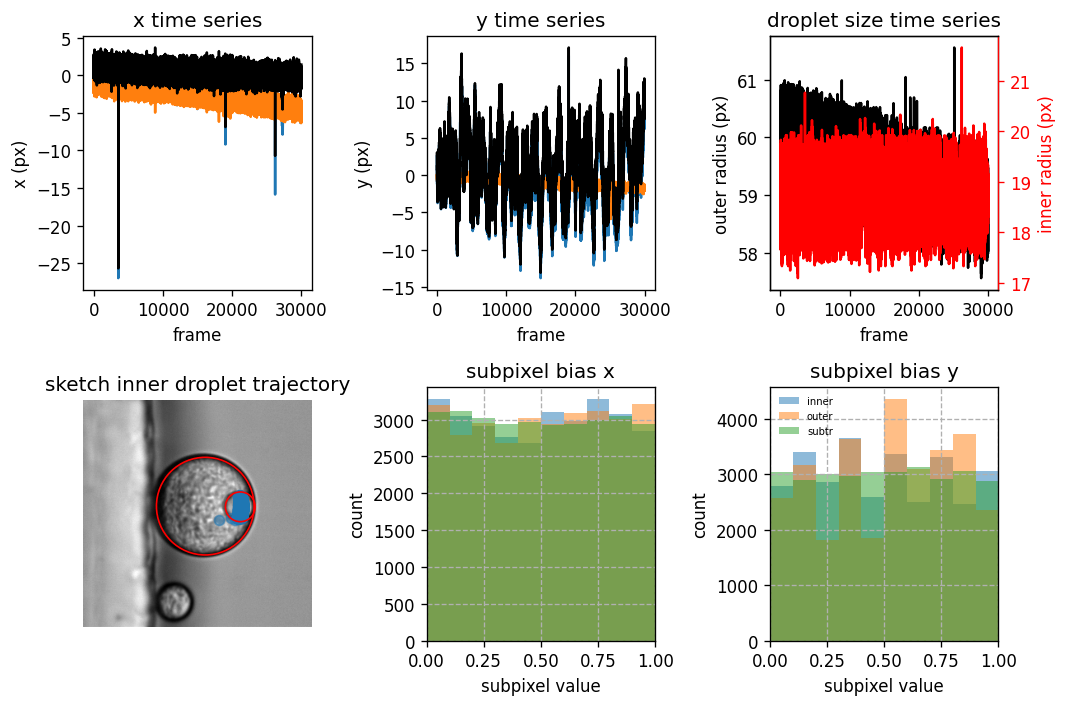

In [10]:
# test subtraction_report()
analysis_folder = r"C:\Users\liuzy\Documents\06012022\Analysis\03"
img_folder = r"D:\DE\06012022\03\8-bit"
subtraction_report(analysis_folder, img_folder)